<a href="https://colab.research.google.com/github/KunalA18/Sketch-2-Paint/blob/main/sketch_2_paint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
from google.colab import drive  
drive.mount('/content/drive/')
'''
mounting the data from google drive to colab

'''

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


'\nmounting the data from google drive to colab\n\n'

In [52]:
import tensorflow as tf

import cv2
import os
import time

from matplotlib import pyplot as plt


In [53]:
PATH = 'drive/MyDrive/data'


In [54]:
EPOCHS = 10
BUFFER_SIZE = 5
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
'''
setting the parameters for training the model
'''

'\nsetting the parameters for training the model\n'

Loading input and output images


In [55]:
def load(image_file):
  '''
  function load() takes the image path as a parameter and returns an input_image which is the black 
  and white sketch that we’ll give as an input to the model, and real_image which is the colored image that we want.

    Parameters:
          image_file(string): a string path
    Returns:
          input_image:black and white sketch
          real_image :colored image which we want
  '''
  image = tf.io.read_file(image_file)
  image = tf.image.decode_png(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

PRE PROCESSING


In [56]:
def resize(input_image, real_image, height, width):
  '''
  resize() function is used to return the images as 286x286 px.
  This is done in order to have a uniform image size if by chance there is a differently sized image in the dataset.
 

    Parameters:
          input_image:black and white sketch
          real_image :colored image which we want
          height: height of the image
          width:width of the image
    Returns:
          input_image:black and white sketch of 286x286 px.
          real_image :colored image which we want of 286x286 px.
  '''
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
  '''
  random_crop() function returns the cropped input and real images which have the desired size of 256x256 px.
  And decreasing size from 512x512 px to half of it also helps in speeding up the model training as it is computationally less heavy.
    Parameters:
         input_image:black and white sketch of 286x286 px.
         real_image :colored image which we want of 286x286 px.
    Returns:
          cropped_image[0]: sketch black and white 256px X 256px image
          cropped_image[1]: coloured 256px X 256px image
          
  '''
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
  stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

def normalize(input_image, real_image):
  '''
  normalize() function  normalizes images to [-1, 1].

    Parameters:
          input_image:black and white sketch after random_jitter for train set and after resize for test set
          real_image :colored image which we want after random_jitter for train set and after resize for test set
         
    Returns:
          input_image:black and white sketch after normalisation
          real_image :colored image which we want after normalisation
  '''
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1
  return input_image, real_image

@tf.function() #decorative function
def random_jitter(input_image, real_image):
  '''
  In the random_jitter() function  all the previous preprocessing functions are put together 
  and random images are flipped horizontally. 
        Parameters:
          input_image:black and white sketch
          real_image :colored image which we want
        Returns:
          input_image:black and white sketch after resize and random_crop
          real_image :colored image which we want after resize and random_crop 
  '''
  input_image, real_image = resize(input_image, real_image, 286, 286)
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image
  

LOADING DATA SET

In [57]:
def load_image_train(image_file):
  '''
  load_image_train() function is used to put together all the previously seen functions and output the final preprocessed image.

    Parameters:
          image_file(string): a string path input taken
    Returns:
          input_image:black and white sketch of train dataset
          real_image :colored image which we want of train dataset
  '''

  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

# To create a dataset of all files matching a pattern, use tf.data.Dataset.list_files   
# For eg:-dataset = tf.data.Dataset.list_files("/path/*.txt") 
train_dataset = tf.data.Dataset.list_files(PATH+'/train/*.png')

# This transformation applies map_func to each element of this dataset, and returns a new dataset containing the transformed elements, 
# in the same order as they appeared in the input. map_func can be used to change both the values and the structure of a dataset's elements.
#  tf.data.AUTOTUNE ==> which will prompt the tf.data runtime to tune the value dynamically at runtime. 
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)


# Randomly shuffles the elements of this dataset.
# This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, 
# replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or 
# equal to the full size of the dataset is required.
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.take(10) 

# For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, 
# then shuffle will initially select a random element from only the first 1,000 elements in the buffer. 
# Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.

In [58]:
def load_image_test(image_file):
  '''
  function load() takes the image path as a parameter and returns an input_image which is the black 
  and white sketch that we’ll give as an input to the model, and real_image which is the colored image that we want.

    Parameters:
          image_file(string): a string path input taken
    Returns:
          input_image:black and white sketch of test dataset
          real_image :colored image which we want of test dataset
  '''

  input_image, real_image = load(image_file)
# resize() function is used to return the images as 286x286 px. This is done in order to have a uniform image size 
# if by chance there is a differently sized image in the dataset. 
# And decreasing size from 512x512 px to half of it also helps in speeding up the model training as it is computationally less heavy.
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
# normalize() function, as the name suggests, normalizes images to [-1, 1].
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image
  
test_dataset = tf.data.Dataset.list_files(PATH+'/val/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)
# Explaination of above 3 functions is mentioned in above code block.

GENERATOR MODEL

In [59]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, shape, apply_batchnorm=True):
  '''
  function downsample(): the downsampling stack of layers has Convolutional layers which result in a decrease in the size of the input image.
    Parameters:
         filters:no of filters used during convolution
         size:size of image
         shape: shape of image
         apply_batchnorm: applying batchnormalisation with a default value true 
    Returns:
         result: result of the downsampled image
  '''

    
# Initializer that generates tensors with a normal distribution.Initializers allow you to pre-specify an initialization strategy, 
# encoded in the Initializer object, without knowing the shape and dtype of the variable being initialized.
# Syntax:
# tf.random_normal_initializer(
#     mean=0.0, stddev=0.05, seed=None
# )
  initializer = tf.random_normal_initializer(0., 0.02)

   
#  Sequential groups a linear stack of layers into a tf.keras.Model.Inherits From: Model, Layer, Module
  result = tf.keras.Sequential()

# 2D convolution layer (e.g. spatial convolution over images).
# This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. 
# If use_bias is True, a bias vector is created and added to the outputs. Finally, if activation is not None, it is applied to the outputs as well.
# When using this layer as the first layer in a model, provide the keyword argument input_shape (tuple of integers, does not include the sample axis), 
# e.g. input_shape=(128, 128, 3) for 128x128 RGB pictures in data_format="channels_last"
  result.add(
    tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', batch_input_shape=shape, 
                             kernel_initializer=initializer, use_bias=False))

# Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
# Leaky version of a Rectified Linear Unit. Inherits From: Layer, Module.It allows a small gradient when the unit is not active
  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, shape, apply_dropout=False):
  '''
  function upsample(): The decreased image after downsampling goes through the upsampling stack of layers which has kind of “reverse” Convolutional layers, 
  the size is restored back to 256x256 px. Hence, 
    Parameters:
         filters:no of filters used during convolution
         size:size of image
         shape: shape of image
         apply_dropout: applying dropout with a default value false
    Returns:
         result: result of the upsampled image
  '''


  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  # Transpose of above conv2D layer
  result.add(
  tf.keras.layers.Conv2DTranspose(filters, size, strides=2, batch_input_shape=shape,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

# Applies Dropout to the input.Inherits From: Layer, Module
# The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. 
# Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.
# Note that the Dropout layer only applies when training is set to True such that no values are dropped during inference. 
# When using model.fit, training will be appropriately set to True automatically, and in other contexts, you can set the kwarg explicitly to True when calling the layer.
  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

# Rectified Linear Unit activation function. Inherits From: Layer, Module. With default values, it returns element-wise max(x, 0)
  result.add(tf.keras.layers.ReLU())

  return result

def buildGenerator():
  '''
  function buildGenerator() gives the output of the Generator Model is a 256x256 px image with 3 output channels.
    Returns:
          generator model of 256px X 256px
  '''

# Input() is used to instantiate a Keras tensor.
  inputs = tf.keras.layers.Input(shape=[256,256,3])


  down_stack = [
    downsample(64, 4, (None, 256, 256, 3), apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4, (None, 128, 128, 64)), # (bs, 64, 64, 128)
    downsample(256, 4, (None, 64, 64, 128)), # (bs, 32, 32, 256)
    downsample(512, 4, (None, 32, 32, 256)), # (bs, 16, 16, 512)
    downsample(512, 4, (None, 16, 16, 512)), # (bs, 8, 8, 512)
    downsample(512, 4, (None, 8, 8, 512)), # (bs, 4, 4, 512)
    downsample(512, 4, (None, 4, 4, 512)), # (bs, 2, 2, 512)
    downsample(512, 4, (None, 2, 2, 512)), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, (None, 1, 1, 512), apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, (None, 2, 2, 1024), apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, (None, 4, 4, 1024), apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4, (None, 8, 8, 1024)), # (bs, 16, 16, 1024)
    upsample(256, 4, (None, 16, 16, 1024)), # (bs, 32, 32, 512)
    upsample(128, 4, (None, 32, 32, 512)), # (bs, 64, 64, 256)
    upsample(64, 4, (None, 64, 64, 256)), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
# We have used tanh activation function in the last layer instead of RELU as it improves the training of model and produces better result
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 3)
  
  x = inputs

  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  for up, skip in zip(up_stack, skips):
      x = up(x)
# Functional interface to the Concatenate layer. Returns A tensor, the concatenation of the inputs alongside axis axis.
      x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

generator = buildGenerator()


In [60]:
generator.summary() #gives the model summary of generator output

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_51 (Sequential)      (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
sequential_52 (Sequential)      (None, 64, 64, 128)  131584      sequential_51[0][0]              
__________________________________________________________________________________________________
sequential_53 (Sequential)      (None, 32, 32, 256)  525312      sequential_52[0][0]              
____________________________________________________________________________________________

DISCRIMINATOR MODEL

In [61]:
def downs(filters, size, apply_batchnorm=True):
  '''
  function downs(): the downsampling stack of layers has Convolutional layers which result in a decrease in the size of the input image.
    Parameters:
         filters:no of filters used during convolution
         size:size of image
         shape: shape of image
         apply_batchnorm: applying batchnormalisation with a default value true 
    Returns:
         result: result of the image after applying properties of downs function
  '''

  initializer = tf.random_normal_initializer(0., 0.02) # Here the parameters are mean and standard deviation

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', 
                            kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
      result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def buildDiscriminator():
  '''
  The primary purpose of the discriminator model is to find out which image is from the actual training dataset and which is an output from the generator model.
  '''
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downs(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downs(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downs(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                              kernel_initializer=initializer,
                              use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                              kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)
  
discriminator = buildDiscriminator()

In [62]:
discriminator.summary() #gives the model summary of the Discriminator  output

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_30 (Concatenate)    (None, 256, 256, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_66 (Sequential)      (None, 128, 128, 64) 6144        concatenate_30[0][0]       

LOSS


In [63]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

LAMBDA = 100 # value of LAMBDA is suggested to be kept 100

def generator_loss(disc_generated_output, gen_output, target):
  '''
  The loss for the generator is calculated by finding the sigmoid cross-entropy loss of 
  the output of the generator and an array of ones. This means that we are training it to trick 
  the discriminator in outputting the value as 1, which means that it is a real image. 
  Also, for the output to be structurally similar to the target image, we take L1 loss along with it. 
   Parameters:
         disc_generated_output : output generated by discriminator
         gen_output :output generated by generator
         target : target image which we want
         
    Returns:
         total_gen_loss: formula to calculate the total generator loss is gan_loss + LAMBDA * l1_loss
         gan_loss: Minimax GAN loss refers to the minimax simultaneous optimization of the discriminator and generator models.
         l1_loss: L1 Loss Function is used to minimize the error which is the sum of the all the 
                  absolute differences between the true value and the predicted value.
  '''
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss


def discriminator_loss(disc_real_output, disc_generated_output):
  '''
  For discriminator loss, we take the same sigmoid cross-entropy loss of the real images and an array of ones
  and add it with the cross-entropy loss of the output images of the generator model and array of zeros.
  real_loss is a sigmoid cross-entropy loss of the real images and an array of ones(since these are the real images).
  generated_loss is a sigmoid cross-entropy loss of the generated images and an array of zeros (since these are the fake images).
 
   Parameters:
         disc_generated_output : output generated by discriminator for generated images of generator model
         disc_real_output :output generated by discriminator for real images
     Returns:
         total_disc_loss: formula to calculate the total discriminator loss is the sum of real_loss and generated_loss.     
  '''
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

OPTIMISER


In [64]:
'''
Optimizers are algorithms or methods used to change the attributes of your neural network such as weights and learning rates 
in order to reduce the losses. Adam Optimizer is one of the best ones to use, in most of the use cases.
'''
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

CHECKPOINTS

In [65]:
#Saving checkpoints at regular intervals is necessary so that you can restore to the latest checkpoint
#  and continue from there without losing the previously done hard work by your machines.
checkpoint_dir = './Sketch2Color_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Displaying Output Images

In [66]:
def generate_images(model, test_input, tar):
  '''
  The below-given block of code is a basic python function which uses the pyplot module from matplotlib library 
  to display the predicted images by the generator model.
     Parameters:
         model : trained model is taken as input 
         test_input : input from the test set
         tar : target image what we want   
  '''
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
# Three integers (nrows, ncols, index). The subplot will take the index position on a grid with nrows rows and ncols columns. 
# index starts at 1 in the upper left corner and increases to the right. index can also be a two-tuple 
# specifying the (first, last) indices (1-based, and including last) of the subplot,
#  e.g., fig.add_subplot(3, 1, (1, 2)) makes a subplot that spans the upper 2/3 of the figure.
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
  plt.show()

Logging the Losses


In [67]:
# You can log the important metrics like losses in a file so that you can analyze it as the training progresses on tools like Tensorboard.
import datetime
log_dir="Sketch2Coloe_logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

Train Step

In [68]:
@tf.function
def train_step(input_image, target, epoch):
  '''
  1.  The generator outputs a prediction
  2.  The discriminator model is designed to have 2 inputs at a time. For the first time, it is given an input sketch image and the generated image. 
      The next time it is given the real target image and the generated image.
  3.  Now the generator loss and discriminator loss are calculated.
  4.  Then, the gradients are calculated from the losses and applied to the optimizers to help the generator produce a better image and also to help discriminator detect the real and generated image with better insights.
  5.  All the losses are logged using summary_writer defined previously using tf.summary
     Parameters:
         input_image : input image taken after all preprocessing steps
         target : target image what we want 
         epoch : no of epochs   
  '''
# GradientTape is a mathematical tool for automatic differentiation (autodiff), which is the core functionality of TensorFlow.
# It does not "track" the autodiff, it is a key part of performing the autodiff.
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

      gen_output = generator(input_image, training=True)

      disc_real_output = discriminator([input_image, target], training=True)
      disc_generated_output = discriminator([input_image, gen_output], training=True)

      gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
      disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                        generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                              discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                        generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                            discriminator.trainable_variables))

  with summary_writer.as_default():
      tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
      tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
      tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
      tf.summary.scalar('disc_loss', disc_loss, step=epoch)

Model.fit()

In [69]:
def fit(train_ds, epochs, test_ds):
  '''
  # Here we iterate over for every epoch and assign the relative time to start variable. 
  # Then we display an example of the generated image by the generator model. 
  # This example helps us visualize how the generator gets better at generating better-colored images with every epoch. 
  # Then we call the train_step function for the model to learn from the calculated losses and gradients. 
  # And finally, we check if the epoch number is divisible by 5 to save a checkpoint. 
  # This means that we are saving a checkpoint after every 5 epochs of training are completed.
  # After this entire epoch is completed, the start time is subtracted from the final relative time to count the time taken for that particular epoch. 
      Parameters:
         train_ds : train dataset is taken as input
         test_ds : test dataset is taken as input
         epoch : no of epochs 
        
  '''
 
  for epoch in range(epochs):
    # Record the start time
      start = time.time()

      for example_input, example_target in test_ds.take(1):
          generate_images(generator, example_input, example_target)
      print("Epoch: ", epoch)

      for n, (input_image, target) in train_ds.enumerate():
          print('.', end='')
          if (n+1) % 100 == 0:
              print()
          train_step(input_image, target, epoch)
      print()

      if (epoch + 1) % 5 == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)

# end time -start time =time taken for epoch
      print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))
      
      
  checkpoint.save(file_prefix = checkpoint_prefix)

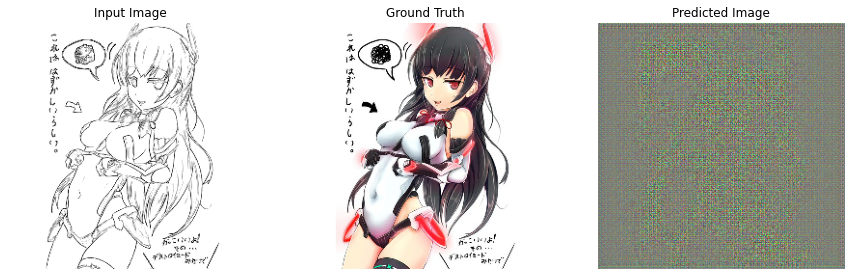

Epoch:  0
..........
Time taken for epoch 1 is 28.590197801589966 sec



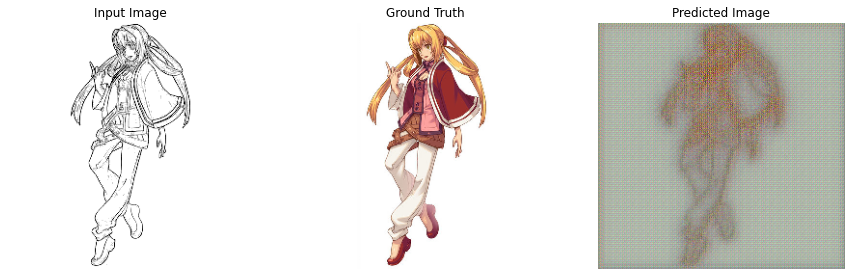

Epoch:  1
..........
Time taken for epoch 2 is 43.53389024734497 sec



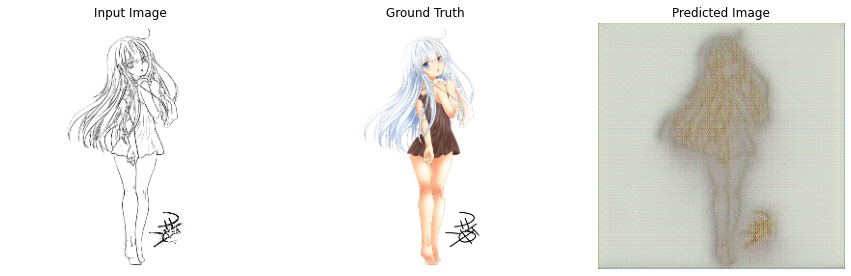

Epoch:  2
..........
Time taken for epoch 3 is 24.988262176513672 sec



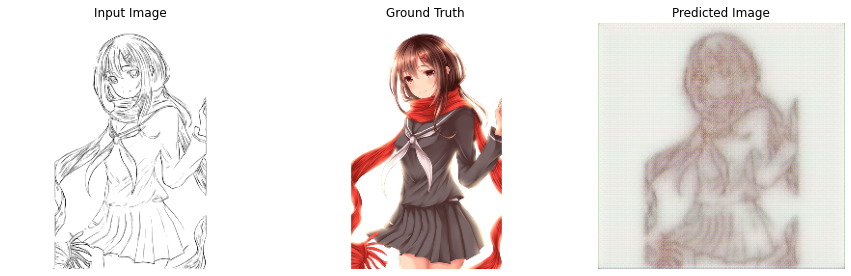

Epoch:  3
..........
Time taken for epoch 4 is 42.25267720222473 sec



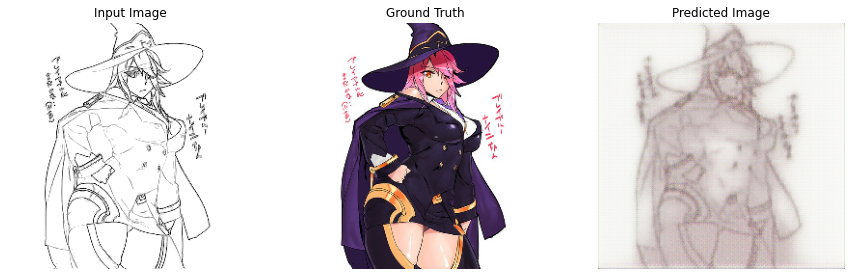

Epoch:  4
..........
Time taken for epoch 5 is 45.25750517845154 sec



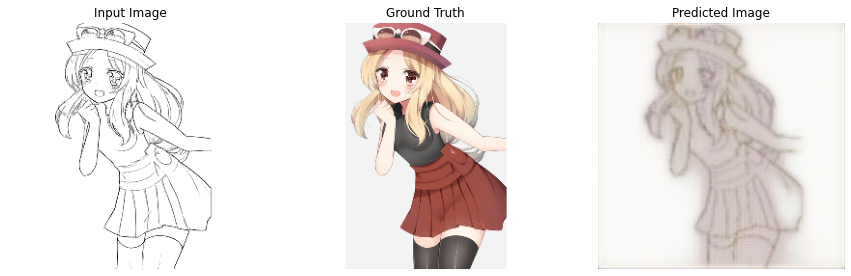

Epoch:  5
..........
Time taken for epoch 6 is 25.802175283432007 sec



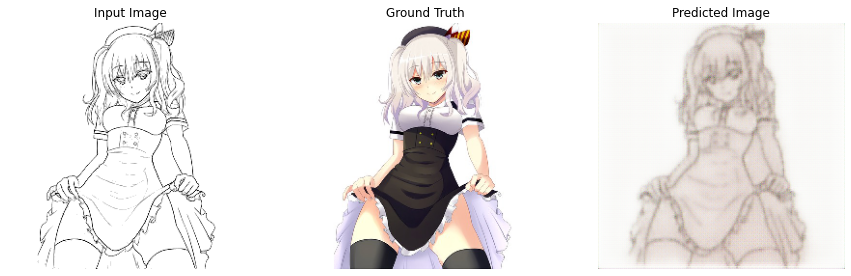

Epoch:  6
..........
Time taken for epoch 7 is 24.750330448150635 sec



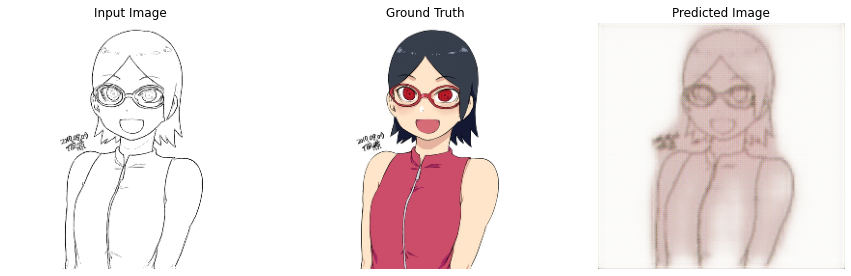

Epoch:  7
..........
Time taken for epoch 8 is 42.31454658508301 sec



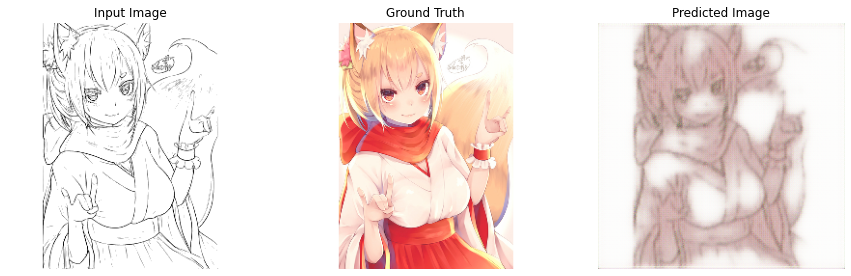

Epoch:  8
..........
Time taken for epoch 9 is 42.07529067993164 sec



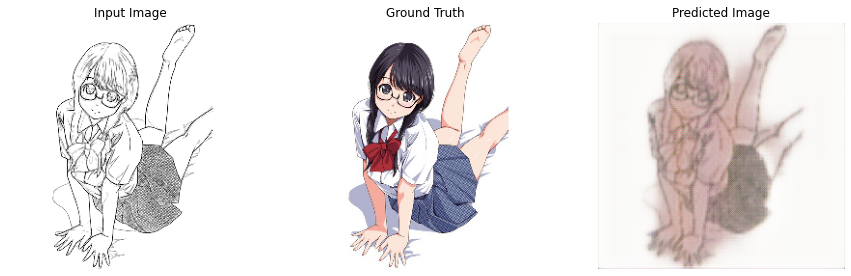

Epoch:  9
..........
Time taken for epoch 10 is 45.845444202423096 sec



In [70]:
fit(train_dataset, EPOCHS, test_dataset) # To train the data and get the expexted output

Restoring the Latest Checkpoint

In [71]:
# Before moving forward, we must restore the latest checkpoint available in order to load the latest version of the trained model before testing it on the images.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


Testing Outputs

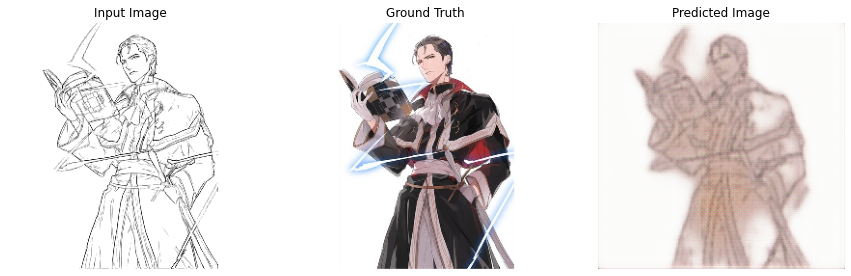

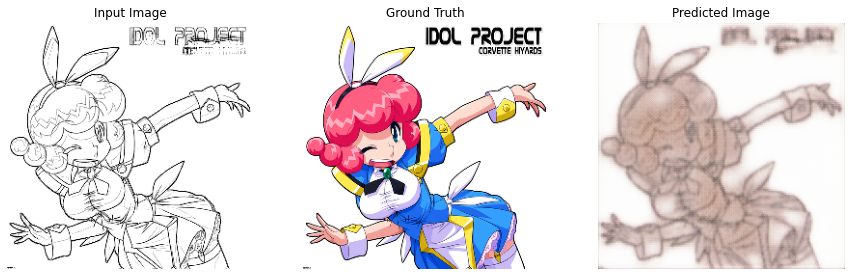

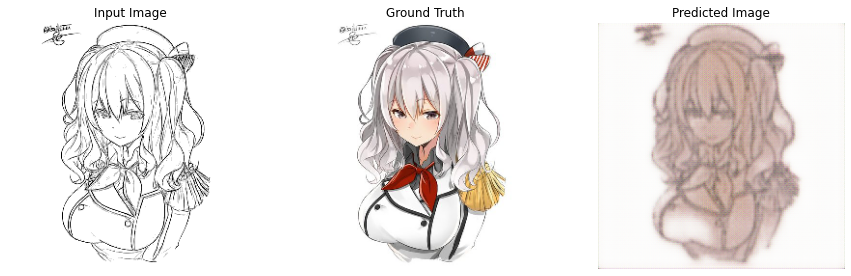

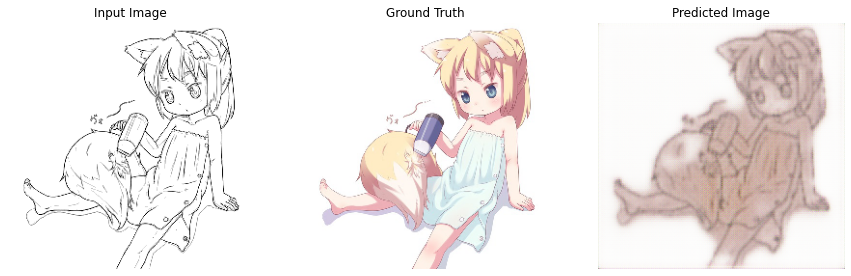

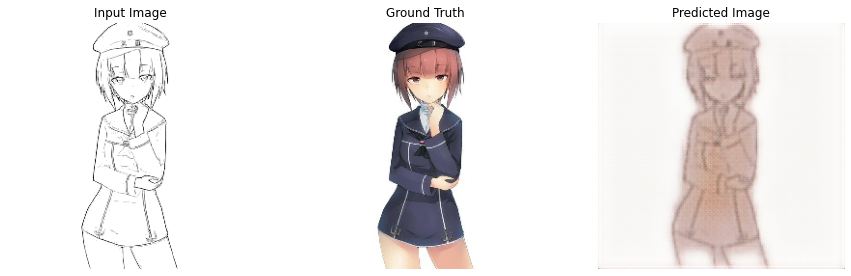

In [72]:
# This randomly selects 5 images from the test_dataset and inputs them individually to the Generator Model. 
# Now the model is trained well enough and predicts near-perfect colored versions of the input sketch images.
for example_input, example_target in test_dataset.take(5):
    generate_images(generator, example_input, example_target)



Saving the Model

In [73]:
# to save the entire model as a .H5 file which is supported by Keras models.
generator.save('AnimeColorizationModelv1.h5')

